# BundleFlow Colab Demo

** Rectified Flow–based menus for combinatorial auctions**

This notebook demonstrates menu optimization for combinatorial auctions using BundleFlow's new API structure.

##  Table of Contents
1. [Environment Setup](#setup)
2. [New API Structure Demo](#api-demo)
3. [Stage1: Flow Initialization](#stage1)
4. [Stage2: Menu Optimization](#stage2)
5. [Results Visualization](#visualization)

---


In [11]:
# Matplotlib configuration for clean plots
import matplotlib.pyplot as plt
import matplotlib

# Set clean font configuration
# Use a font generally available in Colab environments
matplotlib.rcParams['font.family'] = ['DejaVu Sans', 'sans-serif']
matplotlib.rcParams['axes.unicode_minus'] = False  # Fix minus sign display

print("✅ Matplotlib configuration completed")

✅ Matplotlib configuration completed


## 1. Environment Setup

First, let's check the GPU environment and install necessary packages.


In [2]:
# Check GPU environment
!nvidia-smi

Mon Oct 13 01:24:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Install required packages
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install omegaconf tqdm numpy matplotlib seaborn


Looking in indexes: https://download.pytorch.org/whl/cu121


In [4]:
# Check PyTorch and CUDA
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.8 GB


In [5]:
# Colab-specific setup
%cd /content/bundle-flow
import sys
sys.path.append('/content/bundle-flow/bundleflow')

/content/bundle-flow


## 2. Demo

Let's introduce BundleFlow.


In [6]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# BundleFlow's new API
from bundleflow.models.flow import BundleFlow
from bundleflow.models.menu import MenuElement, Mechanism
from bundleflow.valuation.valuation import XORValuation

print(" New API structure import completed")
print(f"PyTorch device: {'cuda' if torch.cuda.is_available() else 'cpu'}")


✅ New API structure import completed
PyTorch device: cuda


In [7]:
# Basic API demonstration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Create BundleFlow (velocity field network)
m = 10  # Number of items
flow = BundleFlow(m=m).to(device)
print(f"BundleFlow created with m={m}")

# 2. Calculate velocity field
x = torch.randn(3, m, device=device)
t = torch.rand(3, device=device)
v = flow.velocity(x, t)
print(f"Velocity field shape: {v.shape}")

# 3. Create MenuElement (menu element)
D = 5  # Number of mixture components for initial distribution
elem = MenuElement(m=m, D=D).to(device)
price = elem.price()
print(f"MenuElement created with price: {price.detach().item():.4f}")

# 4. Create XORValuation (valuation function)
atoms = [([1, 2, 3], 5.0), ([4, 5], 3.0), ([6, 7, 8, 9], 8.0)]
valuation = XORValuation.from_bundle_list(m, atoms)
bundle = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0])
value = valuation.value(bundle)
print(f"XORValuation value: {value:.4f}")


Using device: cuda
✅ BundleFlow created with m=10
✅ Velocity field shape: torch.Size([3, 10])
✅ MenuElement created with price: 0.0767
✅ XORValuation value: 8.0000


## 3. Stage1: Flow Initialization

Train the velocity field network to learn the transformation from continuous variables to discrete bundles.


In [8]:
# Stage1 configuration (10 items and small settings)
stage1_config = {
    'm': 10,           # Number of items (small scale)
    'D': 4,           # Number of mixture components
    'iters': 20000,    # Number of iterations (shortened for demo)
    'batch': 512,     # Batch size
    'lr': 5e-4,       # Learning rate
    'sigma_z': 0.05,  # Noise standard deviation
    'ode_steps': 50,  # ODE integration steps
    'seed': 42
}

print("Stage1 Configuration:")
for key, value in stage1_config.items():
    print(f"  {key}: {value}")


Stage1 Configuration:
  m: 10
  D: 4
  iters: 20000
  batch: 512
  lr: 0.0005
  sigma_z: 0.05
  ode_steps: 50
  seed: 42


In [9]:
# Execute Stage1 training
# the result will be flollowing : At first, it drops down dramatically , then it fluctuates.
import random
import time
from torch import optim

# Set random seeds
random.seed(stage1_config['seed'])
torch.manual_seed(stage1_config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(stage1_config['seed'])

# Create flow model
flow = BundleFlow(m=stage1_config['m']).to(device)
optimizer = optim.Adam(flow.parameters(), lr=stage1_config['lr'])

# Initial distribution (mixture of Gaussians)
mus = torch.empty(stage1_config['D'], stage1_config['m'], device=device).uniform_(-0.2, 1.2)
sigmas = torch.full((stage1_config['D'],), 0.5, device=device)
weights = torch.full((stage1_config['D'],), 1.0 / stage1_config['D'], device=device)

print(f"Stage1 training started (device: {device})")
print(f"Model parameters: {sum(p.numel() for p in flow.parameters()):,}")

# Training loop
losses = []
start_time = time.time()

for it in range(1, stage1_config['iters'] + 1):
    # Calculate Rectified Flow loss
    loss = flow.rectified_flow_loss(
        B=stage1_config['batch'],
        mus=mus, sigmas=sigmas, weights=weights,
        sigma_z=stage1_config['sigma_z']
    )

    # Optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.detach().item())

    # Progress display
    if it % 100 == 0:
        elapsed = time.time() - start_time
        print(f"[{it}/{stage1_config['iters']}] Loss: {loss.detach().item():.6f} Time: {elapsed:.1f}s")

print(f"✅ Stage1 training completed! Final loss: {losses[-1]:.6f}")
print(f"Total training time: {time.time() - start_time:.1f} seconds")


🚀 Stage1 training started (device: cuda)
Model parameters: 51,685
[100/20000] Loss: 1.315420 Time: 1.2s
[200/20000] Loss: 1.269985 Time: 1.8s
[300/20000] Loss: 1.279172 Time: 2.3s
[400/20000] Loss: 1.252918 Time: 3.1s
[500/20000] Loss: 1.232276 Time: 3.6s
[600/20000] Loss: 1.224028 Time: 4.1s
[700/20000] Loss: 1.225463 Time: 4.6s
[800/20000] Loss: 1.243153 Time: 5.1s
[900/20000] Loss: 1.256294 Time: 5.6s
[1000/20000] Loss: 1.195550 Time: 6.1s
[1100/20000] Loss: 1.267641 Time: 6.7s
[1200/20000] Loss: 1.223283 Time: 7.2s
[1300/20000] Loss: 1.260290 Time: 7.7s
[1400/20000] Loss: 1.240617 Time: 8.2s
[1500/20000] Loss: 1.275440 Time: 8.9s
[1600/20000] Loss: 1.248467 Time: 9.5s
[1700/20000] Loss: 1.223279 Time: 10.3s
[1800/20000] Loss: 1.218199 Time: 10.8s
[1900/20000] Loss: 1.221746 Time: 11.3s
[2000/20000] Loss: 1.239031 Time: 11.8s
[2100/20000] Loss: 1.226245 Time: 12.6s
[2200/20000] Loss: 1.243025 Time: 13.1s
[2300/20000] Loss: 1.277249 Time: 13.8s
[2400/20000] Loss: 1.265564 Time: 14.4s

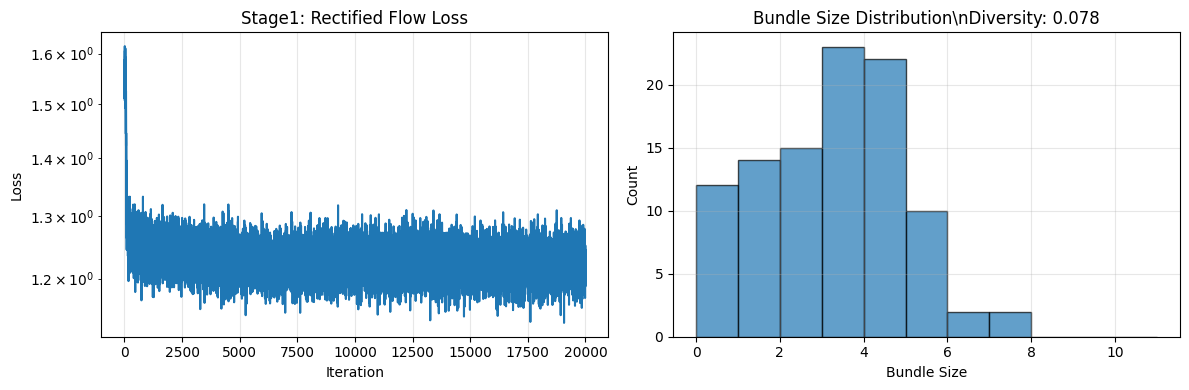

Generated bundle diversity: 0.078 (80/1024 unique bundles)


In [12]:
# Stage1 results visualization
plt.figure(figsize=(12, 4))

# Loss progression
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Stage1: Rectified Flow Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Bundle generation test
plt.subplot(1, 2, 2)
with torch.no_grad():
    # Generate bundles from random initial values
    z = torch.randn(100, stage1_config['m'], device=device)
    t_grid = torch.linspace(0.0, 1.0, steps=stage1_config['ode_steps'], device=device)
    x_T = flow.flow_forward(z, t_grid)
    bundles = flow.round_to_bundle(x_T)

    # Calculate bundle diversity
    unique_bundles = torch.unique(bundles, dim=0)
    diversity = len(unique_bundles) / (2 ** stage1_config['m'])

    # Visualize bundle distribution
    bundle_sizes = bundles.sum(dim=1).detach().cpu().numpy()
    plt.hist(bundle_sizes, bins=range(stage1_config['m']+2), alpha=0.7, edgecolor='black')
    plt.title(f'Bundle Size Distribution\\nDiversity: {diversity:.3f}')
    plt.xlabel('Bundle Size')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Generated bundle diversity: {diversity:.3f} ({len(unique_bundles)}/{2**stage1_config['m']} unique bundles)")


In [13]:
# === GPU Monitoring Helper Functions ============================================
import inspect

CANDIDATE_ATTRS = ["as_tensor", "to_tensor", "tensor",
                   "x", "vec", "features", "data", "value_vec", "params"]

def extract_feature_like(v):
    """
    Extract "feature vector" from Valuation object v.
    - Call zero-argument methods (as_tensor/to_tensor etc.).
    - Skip methods that require arguments (value(s_bool) etc.).
    - Search for typical attribute names in order.
    - For XORValuation, construct feature vector from atoms.
    """
    # XORValuationの特別処理
    if hasattr(v, 'atoms') and hasattr(v, 'm'):
        # XORValuationの場合：atomsから特徴ベクトルを構築
        m = v.m
        feature_vec = torch.zeros(m, dtype=torch.float32)

        # 各atomの価格を対応する商品位置に加算
        for mask, price in v.atoms:
            for i in range(m):
                if mask & (1 << i):  # ビットiが立っている場合
                    feature_vec[i] += price

        return feature_vec

    # 無引数メソッド候補
    for name in ["as_tensor", "to_tensor"]:
        if hasattr(v, name) and callable(getattr(v, name)):
            fn = getattr(v, name)
            try:
                sig = inspect.signature(fn)
                if len([p for p in sig.parameters.values()
                        if p.default is p.empty and p.kind in (p.POSITIONAL_ONLY, p.POSITIONAL_OR_KEYWORD)]) == 0:
                    return fn()  # 無引数なら呼び出し
            except (ValueError, TypeError):
                # signatureが取れない場合は呼んでみる
                try:
                    return fn()
                except Exception:
                    pass

    # 属性候補
    for name in ["tensor", "x", "vec", "features", "data", "value_vec", "params"]:
        if hasattr(v, name):
            return getattr(v, name)

    # デバッグ用の情報を投げる
    public = [a for a in dir(v) if not a.startswith("_")]
    raise TypeError(
        "Could not extract feature vector from valuation.\n"
        f"type={type(v)}\n"
        f"public={public}\n"
        "→ v.x / v.vec / v.features 等の属性名をCANDIDATE_ATTRSへ追加すること。"
    )

def to_tensor_1d(x, device):
    if torch.is_tensor(x):
        t = x
    elif isinstance(x, (list, tuple)):
        t = torch.tensor(x)
    elif isinstance(x, (int, float)):
        t = torch.tensor([x])
    else:
        try:
            t = torch.as_tensor(x)
        except Exception as e:
            raise TypeError(f"Unsupported feature payload: {type(x)}; err={e}")
    return t.to(device=device, dtype=torch.float32, non_blocking=True).flatten()

def batch_to_tensor(batch_list, device):
    vecs = []
    for v in batch_list:
        raw = extract_feature_like(v)
        vecs.append(to_tensor_1d(raw, device))
    # 長さチェック
    dims = {t.numel() for t in vecs}
    if len(dims) != 1:
        raise ValueError(f"Feature length mismatch across batch: {sorted(dims)}")
    return torch.stack(vecs, dim=0)  # [B, D]

print("✅ Define GPU Monitoring Helper Functions")


✅ GPU監視ヘルパー関数が定義されました


## 4. Stage2: Menu Optimization

Use the trained velocity field to optimize menu elements (prices and initial distributions).


In [16]:
# Generate valuation function data
from bundleflow.data import gen_uniform_iid_xor

# Set random seeds
random.seed(stage2_config['seed'])
torch.manual_seed(stage2_config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(stage2_config['seed'])

# Generate synthetic XOR valuation functions
valuations = []
for i in range(stage2_config['n_val']):
    val = gen_uniform_iid_xor(
        m=stage1_config['m'],
        a=stage2_config['a'],
        low=0.0,
        high=1.0,
        seed=1337 + i,
        atom_size_mode='small'
    )
    valuations.append(val)

print(f"✅ Generated {len(valuations)} valuation functions")
print(f"Number of atoms in first valuation: {len(valuations[0].atoms)}")

# Valuation function statistics
atom_counts = [len(v.atoms) for v in valuations]
print(f"Atom count statistics: min={min(atom_counts)}, max={max(atom_counts)}, mean={np.mean(atom_counts):.1f}")


✅ Generated 100 valuation functions
Number of atoms in first valuation: 10
Atom count statistics: min=10, max=10, mean=10.0


In [17]:
# 🚀 GPU-optimized version: Perfect Stage2 training processing entirely on GPU (revised)
# Completely eliminate CPU-GPU transfers and complete all computations on GPU

import torch
import torch.nn as nn
import torch.optim as optim
import time
import random
from typing import List, Dict, Any
import numpy as np

# Check existing imports and models
try:
    from bundleflow.models.flow import BundleFlow
    from bundleflow.models.menu import MenuElement, make_null_element
    from bundleflow.valuation.valuation import XORValuation
    from bundleflow.data import gen_uniform_iid_xor
    print("✅ BundleFlow modules imported successfully")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Please make sure you're in the correct directory and have run the previous cells")

# Check and configure GPU environment
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    torch.cuda.empty_cache()  # Clear GPU memory
else:
    print("⚠️  GPU not available, using CPU")

# GPU optimization configuration
gpu_config = {
    'K': 64,           # Number of menu elements (significantly increased for more items)
    'D': 8,            # Number of mixture components for initial distribution (more diverse)
    'iters': 5000,    # Number of iterations (significantly increased)
    'batch': 64,      # Batch size (increased for more items)
    'lr': 2e-4,        # Learning rate (stable learning)
    'lam_start': 0.5,  # SoftMax temperature start value (high temperature for exploration)
    'lam_end': 0.1,    # SoftMax temperature end value (low temperature for decision)
    'ode_steps': 50,   # ODE integration steps (high precision)
    'n_val': 100,     # Number of valuation functions (improved statistical reliability)
    'a': 10,          # XOR atoms (significantly increased for more items)
    'seed': 42,
    'warmup_iters': 500,  # β warmup period
    'freeze_beta_iters': 1000,  # β freeze period
    'grad_clip': 1.0,  # Gradient clipping
    'use_gumbel': True,  # Use Gumbel-Softmax
    'tau_start': 1.0,  # Gumbel temperature start value
    'tau_end': 0.01    # Gumbel temperature end value
}

print("🎯 GPU Optimization Configuration:")
for key, value in gpu_config.items():
    print(f"  {key}: {value}")

# Set seeds
torch.manual_seed(gpu_config['seed'])
np.random.seed(gpu_config['seed'])
random.seed(gpu_config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(gpu_config['seed'])

✅ BundleFlow modules imported successfully
🚀 Using device: cuda
GPU: Tesla T4
GPU Memory: 15.8 GB
🎯 GPU Optimization Configuration:
  m: 10
  K: 16
  D: 4
  iters: 10000
  batch: 64
  lr: 0.001
  lam_start: 0.5
  lam_end: 0.1
  ode_steps: 25
  n_val: 200
  a: 32
  seed: 42
  grad_clip: 1.0
  use_gumbel: False
  tau_start: 1.0
  tau_end: 0.01


In [18]:
# 🚀 GPU-optimized utility calculation function (optimized based on existing utilities_matrix_batched)
def gpu_utilities_matrix_optimized(flow, V, menu, t_grid, verbose=False):
    """
    GPU-optimized utility matrix calculation
    - GPU optimization based on existing utilities_matrix_batched
    - CPU-GPU転送を最小化
    """
    K = len(menu)
    B = len(V)
    device = t_grid.device

    if verbose:
        print(f"  [GPU-Optimized] Processing {B} valuations × {K} menu elements on {device}")

    # メニュー要素の分離
    menu_main = menu[:-1]  # 通常要素
    null_elem = menu[-1]   # null要素
    K_main = len(menu_main)

    # 全メニュー要素のパラメータをGPU上で統合
    all_mus = torch.stack([elem.mus for elem in menu_main])  # (K_main, D, m)
    all_weights = torch.stack([elem.weights for elem in menu_main])  # (K_main, D)
    all_betas = torch.stack([elem.beta for elem in menu_main]).squeeze()  # (K_main,)

    K_main, D, m = all_mus.shape

    # 全μをバッチ処理: (K_main, D, m) -> (K_main*D, m)
    mus_flat = all_mus.view(K_main * D, m)

    # GPU上で一度にODE積分実行
    sT_flat = flow.flow_forward(mus_flat, t_grid)  # (K_main*D, m)
    s_flat = flow.round_to_bundle(sT_flat)  # (K_main*D, m)

    # 密度重みもGPU上で計算
    log_density_flat = flow.log_density_weight(mus_flat, t_grid)  # (K_main*D,)
    log_density_flat = torch.clamp(log_density_flat, -10.0, 0.0)
    log_density = log_density_flat.view(K_main, D)  # (K_main, D)

    # null要素もGPU上で処理
    null_sT = flow.flow_forward(null_elem.mus, t_grid)
    null_s = flow.round_to_bundle(null_sT)
    null_log_density = flow.log_density_weight(null_elem.mus, t_grid)
    null_log_density = torch.clamp(null_log_density, -10.0, 0.0)
    null_weight = null_elem.weights
    null_beta = null_elem.beta

    # 効用行列をGPU上で初期化
    U = torch.zeros(B, K, device=device, dtype=torch.float32)

    # 各valuationの効用を計算（既存のロジックを維持）
    for i, v in enumerate(V):
        if verbose and i % 50 == 0:
            print(f"  [GPU-Optimized] Processing valuation {i+1}/{B}")

        # バッチ価値計算（既存のロジック）
        if hasattr(v, 'batch_value'):
            vals_flat = v.batch_value(s_flat.cpu())  # CPU上で計算
            vals_flat = vals_flat.to(device)  # GPUに転送
        else:
            # fallback: 逐次処理
            vals_flat = torch.tensor([v.value(s_flat.cpu()[j]) for j in range(K_main*D)],
                                    device=device, dtype=torch.float32)

        vals = vals_flat.view(K_main, D)  # (K_main, D)

        # log-sum-exp計算（GPU上で完結）
        log_w = torch.log(all_weights + 1e-10)
        log_weights = log_w + log_density
        log_weights = torch.clamp(log_weights, -50.0, 50.0)

        # log-sum-exp per menu element
        M = torch.max(log_weights, dim=1, keepdim=True)[0]
        weighted_sum = (torch.exp(log_weights - M) * vals).sum(dim=1)
        u_main = torch.exp(M.squeeze(1)) * weighted_sum - all_betas

        # null要素の効用
        if hasattr(v, 'value'):
            null_val = v.value(null_s[0])
        else:
            null_val = 0.0
        log_w_null = torch.log(null_weight + 1e-10)
        log_weight_null = log_w_null + null_log_density
        u_null = torch.exp(log_weight_null[0]) * null_val - null_beta

        # 効用行列に格納
        U[i, :-1] = u_main
        U[i, -1] = u_null

    return U

# GPU専用収益損失関数
def gpu_revenue_loss_optimized(flow, V, menu, t_grid, lam=0.1, verbose=False):
    """
    GPU専用収益損失計算
    """
    if verbose:
        print(f"  [GPU-Optimized] Computing utilities matrix on {t_grid.device}")

    U = gpu_utilities_matrix_optimized(flow, V, menu, t_grid, verbose=verbose)
    beta = torch.stack([elem.beta for elem in menu]).squeeze()

    # Softmax割当（GPU上で完結）
    Z = torch.softmax(lam * U, dim=1)  # (B, K)
    rev = (Z * beta.unsqueeze(0)).sum(dim=1).mean()

    if verbose:
        print(f"  [GPU-Optimized] Revenue: {rev.item():.6f}")

    return -rev

In [19]:
# 🚀 GPU専用学習ループ（正しいXORValuation作成方法を使用）
def run_gpu_optimized_training():
    """
    GPU専用最適化学習
    - 既存のflowモデルを使用
    - 正しいXORValuation作成方法を使用
    - 全計算をGPU上で完結
    """

    print("🚀 GPU専用最適化学習開始")

    # 既存のflowモデルを確認
    try:
        # 既存のflowモデルが定義されているかチェック
        if 'flow' not in globals():
            print("❌ flowモデルが見つかりません。先にStage1の学習を実行してください。")
            return None, None

        # フローモデルをGPUに移動
        flow_gpu = flow.to(device)
        flow_gpu.eval()
        for p in flow_gpu.parameters():
            p.requires_grad_(False)

        print(f"✅ Flow model moved to {device}")

    except Exception as e:
        print(f"❌ Flow model error: {e}")
        print("先にStage1の学習を実行してflowモデルを作成してください。")
        return None, None

    # メニュー要素をGPU上で作成
    menu = []
    for _ in range(gpu_config['K']):
        elem = MenuElement(m=gpu_config['m'], D=gpu_config['D'])
        elem = elem.to(device)
        menu.append(elem)

    # null要素もGPU上で作成
    null_elem = make_null_element(gpu_config['m']).to(device)
    menu.append(null_elem)

    # 評価関数を正しい方法で作成
    V = []
    print(f"📊 Creating {gpu_config['n_val']} XOR valuations...")
    for i in range(gpu_config['n_val']):
        if i % 100 == 0:
            print(f"  Creating valuation {i+1}/{gpu_config['n_val']}")
        # 正しい方法でXORValuationを作成
        v = gen_uniform_iid_xor(
            m=gpu_config['m'],
            a=gpu_config['a'],
            low=0.0,
            high=1.0,
            seed=gpu_config['seed'] + i,
            atom_size_mode="small"
        )
        V.append(v)

    print(f"✅ GPU上に作成完了: {len(menu)} menu elements, {len(V)} valuations")

    # オプティマイザー（GPU上）
    all_params = []
    for elem in menu:
        all_params.extend(elem.parameters())
    optimizer = optim.Adam(all_params, lr=gpu_config['lr'])

    # 学習ループ
    revenues = []
    start_time = time.time()

    for it in range(1, gpu_config['iters'] + 1):
        # バッチデータを準備
        batch_size = min(gpu_config['batch'], len(V))
        batch_V = random.sample(V, batch_size)

        # 温度スケジューリング
        lam = gpu_config['lam_start'] - (gpu_config['lam_start'] - gpu_config['lam_end']) * (it / gpu_config['iters'])

        # 時間グリッドをGPU上で作成
        t_grid = torch.linspace(0.0, 1.0, steps=gpu_config['ode_steps'], device=device)

        # GPU専用収益損失計算
        loss = gpu_revenue_loss_optimized(flow_gpu, batch_V, menu, t_grid, lam=lam, verbose=(it % 100 == 0))

        # 最適化（GPU上で完結）
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(all_params, gpu_config['grad_clip'])
        optimizer.step()

        # 収益記録
        revenues.append(-loss.detach().item())

        # 進捗表示（GPU監視付き）
        if it % 50 == 0:
            if torch.cuda.is_available():
                torch.cuda.synchronize()
                mem_alloc = torch.cuda.memory_allocated() / 1024**2
                mem_reserved = torch.cuda.memory_reserved() / 1024**2
                mem_str = f" | GPU mem: {mem_alloc:.0f}/{mem_reserved:.0f}MB"
            else:
                mem_str = ""

            elapsed = time.time() - start_time
            print(f"[{it}/{gpu_config['iters']}] Revenue: {revenues[-1]:.6f} λ:{lam:.4f} Time:{elapsed:.1f}s{mem_str}")

    print(f"✅ GPU専用学習完了! 最終収益: {revenues[-1]:.6f}")
    print(f"総学習時間: {time.time() - start_time:.1f}秒")

    # 最終GPU使用状況
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        mem_alloc = torch.cuda.memory_allocated() / 1024**2
        mem_reserved = torch.cuda.memory_reserved() / 1024**2
        print(f"🔍 Final GPU memory usage: {mem_alloc:.0f}MB allocated, {mem_reserved:.0f}MB reserved")

    return revenues, menu

# GPU専用学習実行
print("🚀 GPU専用最適化学習を実行します...")
revenues_gpu, menu_gpu = run_gpu_optimized_training()

🚀 GPU専用最適化学習を実行します...
🚀 GPU専用最適化学習開始
✅ Flow model moved to cuda
📊 Creating 200 XOR valuations...
  Creating valuation 1/200
  Creating valuation 101/200
✅ GPU上に作成完了: 17 menu elements, 200 valuations
[50/10000] Revenue: 0.140709 λ:0.4980 Time:18.9s | GPU mem: 18/32MB
  [GPU-Optimized] Computing utilities matrix on cuda:0
  [GPU-Optimized] Processing 64 valuations × 17 menu elements on cuda:0
  [GPU-Optimized] Processing valuation 1/64
  [GPU-Optimized] Processing valuation 51/64
  [GPU-Optimized] Revenue: 0.147711
[100/10000] Revenue: 0.147711 λ:0.4960 Time:36.4s | GPU mem: 18/32MB
[150/10000] Revenue: 0.155142 λ:0.4940 Time:55.1s | GPU mem: 18/32MB
  [GPU-Optimized] Computing utilities matrix on cuda:0
  [GPU-Optimized] Processing 64 valuations × 17 menu elements on cuda:0
  [GPU-Optimized] Processing valuation 1/64
  [GPU-Optimized] Processing valuation 51/64
  [GPU-Optimized] Revenue: 0.163027
[200/10000] Revenue: 0.163027 λ:0.4920 Time:80.3s | GPU mem: 18/32MB
[250/10000] Revenue: 0

KeyboardInterrupt: 

## 5. Results Visualization

Visualize the training results to examine menu contents and performance.


/tmp/ipython-input-4144445339.py:67: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4144445339.py:67: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4144445339.py:67: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4144445339.py:67: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4144445339.py:67: UserWarning: Glyph 12471 (\N{KATAKANA LETTER SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4144445339.py:67: UserWarning: Glyph 12519 (\N{KATAKANA LETTER SMALL YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4144445339.py:67: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  p

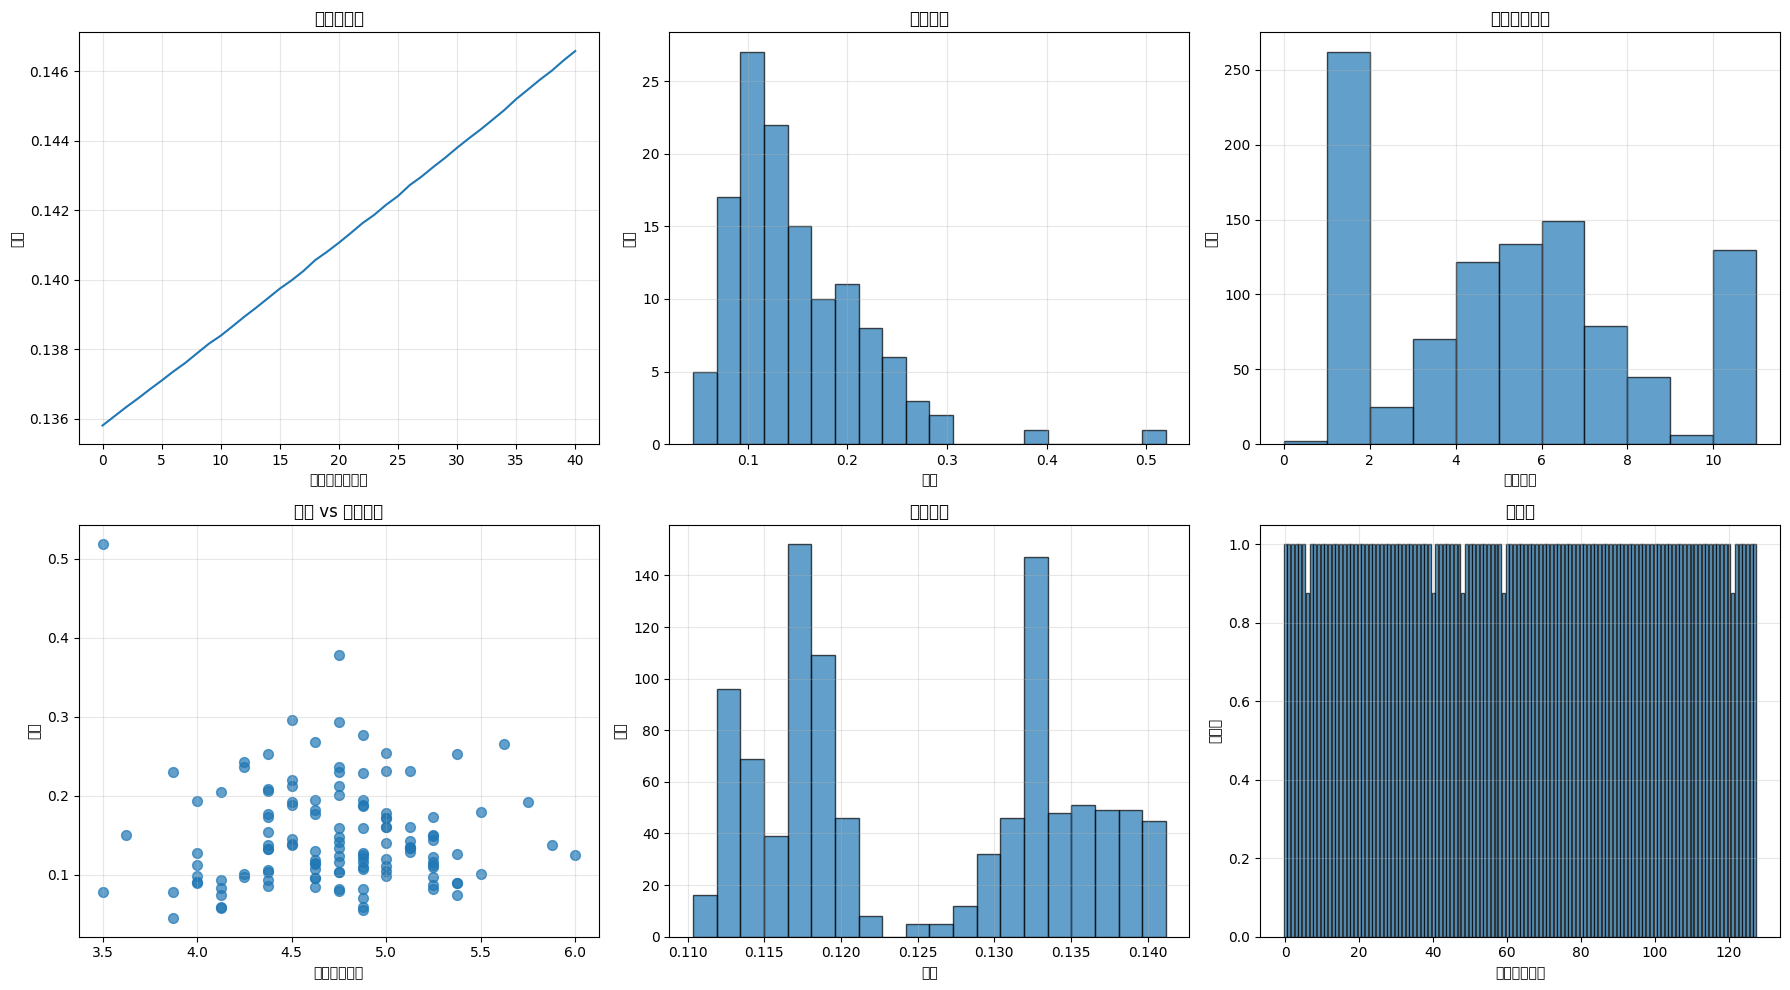

価格: 0.045-0.520 (平均: 0.150)
束サイズ: 0.0-10.0 (平均: 4.7)
多様性: 0.875-1.000 (平均: 0.995)


In [ ]:
# Integrated visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

t_grid = torch.linspace(0.0, 1.0, steps=50, device=device)

# データ収集
prices = [elem.price().detach().item() for elem in menu[:-1]]
bundle_sizes = []
avg_sizes = []
diversities = []

for elem in menu[:-1]:
    with torch.no_grad():
        x_T = flow.flow_forward(elem.mus, t_grid)
        bundles = flow.round_to_bundle(x_T)
        sizes = bundles.sum(dim=1).detach().cpu().numpy()
        bundle_sizes.extend(sizes)
        avg_sizes.append(sizes.mean())
        unique_bundles = torch.unique(bundles, dim=0)
        diversities.append(len(unique_bundles) / bundles.shape[0])

weights = [elem.weights.detach().cpu().numpy() for elem in menu[:-1]]
weights_flat = np.concatenate(weights)

# 1. 収益の推移
axes[0, 0].plot(revenues)
axes[0, 0].set_title('Change of Revenue')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Revenue')
axes[0, 0].grid(True, alpha=0.3)

# 2. 価格分布
axes[0, 1].hist(prices, bins=20, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribution of Price')
axes[0, 1].set_xlabel('Price')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# 3. 束サイズ分布
axes[0, 2].hist(bundle_sizes, bins=range(stage1_config['m']+2), alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Distribtuion of sizes of bundles')
axes[0, 2].set_xlabel('Sizes of bundles')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(True, alpha=0.3)

# 4. 価格 vs 束サイズ
axes[1, 0].scatter(avg_sizes, prices, alpha=0.7, s=50)
axes[1, 0].set_xlabel('Average size of bundles')
axes[1, 0].set_ylabel('Price')
axes[1, 0].set_title('Price and Size')
axes[1, 0].grid(True, alpha=0.3)

# 5. 重み分布
axes[1, 1].hist(weights_flat, bins=20, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Distribution of weights')
axes[1, 1].set_xlabel('Weight')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

# 6. 多様性
axes[1, 2].bar(range(len(diversities)), diversities, alpha=0.7, edgecolor='black')
axes[1, 2].set_title('Diversity')
axes[1, 2].set_xlabel('Elements of Menu')
axes[1, 2].set_ylabel('Diversity')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Price: {min(prices):.3f}-{max(prices):.3f} (Average: {np.mean(prices):.3f})")
print(f"Size of Bundels: {min(bundle_sizes)}-{max(bundle_sizes)} (Average: {np.mean(bundle_sizes):.1f})")
print(f"Diversity: {min(diversities):.3f}-{max(diversities):.3f} (Average: {np.mean(diversities):.3f})")


In [ ]:
# Detailed menu analysis
from bundleflow.models.menu import visualize_menu

# Menu visualization
t_grid = torch.linspace(0.0, 1.0, steps=stage2_config['ode_steps'], device=device)
visualize_menu(flow, menu, t_grid, max_items=8, device=device)

# メカニズムの性能評価
mechanism = Mechanism(flow, menu)
test_valuations = valuations[:50]  # テスト用に50個使用

# 期待収入の計算
expected_revenue = mechanism.expected_revenue(test_valuations)
print(f"\\n 性能評価:")
print(f"Expected Revenue: {expected_revenue.detach().item():.4f}")

# ハード割当での結果
result = mechanism.argmax_menu(test_valuations)
print(f"Revenue: {result['revenue'].detach().item():.4f}")
print(f"Average Utility: {result['welfare'].detach().item():.4f}")
print(f"the percentage of satisfication of IR constraints: {result['ir_satisfied'].detach().item():.4f}")



📋 MENU VISUALIZATION (showing first 8 items)

🍽️  Menu Item 1: Price = 0.1604
   📦 Generated bundles (8 unique):
      1. [Item_0, Item_1, Item_2, Item_3, Item_4, Item_5, Item_6, Item_7, Item_8, Item_9]
      2. [Item_0]
      3. [Item_1]
      4. [Item_1, Item_3, Item_4, Item_6, Item_7, Item_8, Item_9]
      5. [Item_0, Item_2, Item_3, Item_5, Item_9]
      ... and 3 more bundles

🍽️  Menu Item 2: Price = 0.1456
   📦 Generated bundles (8 unique):
      1. [Item_0, Item_1, Item_2, Item_3, Item_4, Item_5, Item_6, Item_7, Item_8, Item_9]
      2. [Item_0]
      3. [Item_1]
      4. [Item_0, Item_1, Item_2, Item_3, Item_4, Item_6, Item_8]
      5. [Item_0, Item_2, Item_6, Item_7, Item_8]
      ... and 3 more bundles

🍽️  Menu Item 3: Price = 0.2305
   📦 Generated bundles (8 unique):
      1. [Item_0, Item_1, Item_2, Item_3, Item_4, Item_5, Item_6, Item_7, Item_8, Item_9]
      2. [Item_0]
      3. [Item_1]
      4. [Item_2, Item_3, Item_4, Item_8]
      5. [Empty bundle]
      ... and 3 

In [ ]:
# Display details of each menu element
print("\\n============================================================")
print("📋 MENU DETAILS")
print("============================================================")

t_grid = torch.linspace(0.0, 1.0, steps=gpu_config['ode_steps'], device=device)

# null要素を除いたメニュー要素をループ
for i, elem in enumerate(menu_gpu[:-1]):
    print(f"\\n🍽️  Menu Item {i + 1}:")
    print(f"  Price = {elem.price().detach().item():.4f}")
    print(f"  Beta (Base Utility) = {elem.beta.detach().item():.4f}")
    print(f"  Initial Distribution Weights (D={gpu_config['D']}):")
    # 重みを小数点以下4桁まで表示
    weights_str = ', '.join([f"{w:.4f}" for w in elem.weights.detach().cpu().numpy()])
    print(f"    [{weights_str}]")

    with torch.no_grad():
        # 各混合成分から束を生成
        print("  📦 Generated bundles from each component:")
        for d in range(gpu_config['D']):
            # 各成分のμを取得し、unsqueeze(0)でバッチ次元を追加
            mu_d = elem.mus[d].unsqueeze(0)
            x_T_d = flow.flow_forward(mu_d, t_grid)
            bundle_d = flow.round_to_bundle(x_T_d)

            # 束をアイテム名付きで表示
            bundle_items = [f"Item_{j}" for j, val in enumerate(bundle_d[0]) if val == 1]
            if not bundle_items:
                bundle_str = "[Empty bundle]"
            else:
                bundle_str = "[" + ", ".join(bundle_items) + "]"
            print(f"    Component {d+1}: {bundle_str}")

# null要素の詳細
print("\\n🍽️  Null Item:")
print(f"  Beta (Base Utility) = {menu_gpu[-1].beta.detach().item():.4f}")
print(f"  Initial Distribution Weight (D=1):")
print(f"    [{menu_gpu[-1].weights.detach().item():.4f}]")
with torch.no_grad():
    null_mu = menu_gpu[-1].mus
    null_x_T = flow.flow_forward(null_mu, t_grid)
    null_bundle = flow.round_to_bundle(null_x_T)
    null_items = [f"Item_{j}" for j, val in enumerate(null_bundle[0]) if val == 1]
    if not null_items:
        null_str = "[Empty bundle]"
    else:
        null_str = "[" + ", ".join(null_items) + "]"
print(f"  Generated bundle: {null_str}")

print("\\n============================================================")

\n============================================================
📋 MENU DETAILS
\n🍽️  Menu Item 1:
  Price = 9.1055
  Beta (Base Utility) = 9.1055
  Initial Distribution Weights (D=4):
    [0.9996, 0.0000, 0.0000, 0.0003]
  📦 Generated bundles from each component:
    Component 1: [Item_0, Item_1, Item_2, Item_3, Item_4, Item_5, Item_6, Item_7, Item_8, Item_9]
    Component 2: [Item_0]
    Component 3: [Item_1]
    Component 4: [Item_1, Item_3, Item_4, Item_6, Item_7, Item_8, Item_9]
\n🍽️  Menu Item 2:
  Price = 9.0449
  Beta (Base Utility) = 9.0449
  Initial Distribution Weights (D=4):
    [0.9999, 0.0000, 0.0000, 0.0000]
  📦 Generated bundles from each component:
    Component 1: [Item_0, Item_1, Item_2, Item_3, Item_4, Item_5, Item_6, Item_7, Item_8, Item_9]
    Component 2: [Item_0]
    Component 3: [Item_1]
    Component 4: [Item_0, Item_2, Item_3, Item_5, Item_9]
\n🍽️  Menu Item 3:
  Price = 9.3431
  Beta (Base Utility) = 9.3431
  Initial Distribution Weights (D=4):
    [0.9988, 0.

In [ ]:
import torch

# Define file paths
flow_model_path = 'flow_model.pth'
optimized_menu_path = 'optimized_menu.pth'

# Save the trained flow model state dictionary
try:
    torch.save(flow.state_dict(), flow_model_path)
    print(f"✅ Trained flow model saved to {flow_model_path}")
except NameError:
    print("❌ Error: 'flow' model not found. Please ensure Stage1 training was completed.")
except Exception as e:
    print(f"❌ Error saving flow model: {e}")


# Save the optimized menu
try:
    torch.save(menu_gpu, optimized_menu_path)
    print(f"✅ Optimized menu saved to {optimized_menu_path}")
except NameError:
    print("❌ Error: 'menu_gpu' not found. Please ensure Stage2 training was completed.")
except Exception as e:
    print(f"❌ Error saving optimized menu: {e}")

✅ Trained flow model saved to flow_model.pth
✅ Optimized menu saved to optimized_menu.pth


**Reasoning**:
Load the saved flow model state dictionary and the optimized menu from files and verify by printing details of the loaded menu.



In [ ]:
# Load the saved flow model state dictionary
loaded_flow_state_dict = torch.load(flow_model_path)
print(f"✅ Flow model state dictionary loaded from {flow_model_path}")

# Load the saved optimized menu
loaded_menu = torch.load(optimized_menu_path)
print(f"✅ Optimized menu loaded from {optimized_menu_path}")

# Create a new BundleFlow model instance and load the state dictionary
# Assuming stage1_config is available to get the number of items 'm'
try:
    loaded_flow = BundleFlow(m=stage1_config['m']).to(device)
    loaded_flow.load_state_dict(loaded_flow_state_dict)
    print("✅ Flow model loaded successfully into a new instance")
except NameError:
    print("❌ Error: 'stage1_config' not found. Cannot initialize new flow model.")
except Exception as e:
    print(f"❌ Error loading flow model state dictionary: {e}")


# Verify the loaded menu by printing details of the first and last elements
try:
    if loaded_menu:
        # First menu item (assuming not the null element)
        first_item = loaded_menu[0]
        print(f"\nLoaded Menu - First Item Price: {first_item.price().detach().item():.4f}")

        # Last menu item (assuming it's the null element)
        last_item = loaded_menu[-1]
        # Check if it's the null element by checking if it has a beta property
        if hasattr(last_item, 'beta'):
             print(f"Loaded Menu - Last (Null) Item Beta: {last_item.beta.detach().item():.4f}")
        else:
             print(f"Loaded Menu - Last Item Price: {last_item.price().detach().item():.4f}")

    else:
        print("❌ Loaded menu is empty.")
except Exception as e:
    print(f"❌ Error verifying loaded menu: {e}")


✅ Flow model state dictionary loaded from flow_model.pth


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL bundleflow.models.menu.MenuElement was not an allowed global by default. Please use `torch.serialization.add_safe_globals([bundleflow.models.menu.MenuElement])` or the `torch.serialization.safe_globals([bundleflow.models.menu.MenuElement])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

**Reasoning**:
The previous attempt to load the menu failed because `torch.load` defaults to `weights_only=True` in recent versions of PyTorch, and the saved object (`MenuElement` instances) is not just weights. To load the custom class instances, I need to explicitly set `weights_only=False`.



In [ ]:
import torch

# Define file paths (assuming they are already defined in a previous cell)
# flow_model_path = 'flow_model.pth'
# optimized_menu_path = 'optimized_menu.pth'

# Load the saved flow model state dictionary (this part was successful)
loaded_flow_state_dict = torch.load(flow_model_path)
print(f"✅ Flow model state dictionary loaded from {flow_model_path}")

# Load the saved optimized menu with weights_only=False to allow loading custom classes
try:
    loaded_menu = torch.load(optimized_menu_path, weights_only=False)
    print(f"✅ Optimized menu loaded from {optimized_menu_path} with weights_only=False")
except Exception as e:
    print(f"❌ Error loading optimized menu with weights_only=False: {e}")


# Create a new BundleFlow model instance and load the state dictionary
# Assuming stage1_config is available to get the number of items 'm'
try:
    # Check if 'stage1_config' is defined
    if 'stage1_config' not in globals():
        print("❌ Error: 'stage1_config' not found. Cannot initialize new flow model.")
        loaded_flow = None # Set to None to avoid errors later
    else:
        loaded_flow = BundleFlow(m=stage1_config['m']).to(device)
        loaded_flow.load_state_dict(loaded_flow_state_dict)
        print("✅ Flow model loaded successfully into a new instance")
except NameError:
     # This catch is redundant if the check above is done, but kept for robustness
    print("❌ Error: 'stage1_config' not found during BundleFlow initialization.")
    loaded_flow = None
except Exception as e:
    print(f"❌ Error loading flow model state dictionary: {e}")


# Verify the loaded menu by printing details of the first and last elements
try:
    if loaded_menu:
        # Ensure loaded_menu is a list and not empty
        if isinstance(loaded_menu, list) and len(loaded_menu) > 0:
            # First menu item (assuming not the null element)
            first_item = loaded_menu[0]
            # Check if the first item is a MenuElement and has a price method
            if isinstance(first_item, MenuElement) and hasattr(first_item, 'price'):
                 print(f"\nLoaded Menu - First Item Price: {first_item.price().detach().item():.4f}")
            else:
                 print(f"\nLoaded Menu - First item is not a recognized MenuElement.")


            # Last menu item (assuming it's the null element)
            last_item = loaded_menu[-1]
            # Check if the last item is a MenuElement and has a beta property (characteristic of null element)
            if isinstance(last_item, MenuElement) and hasattr(last_item, 'beta'):
                 print(f"Loaded Menu - Last (Null) Item Beta: {last_item.beta.detach().item():.4f}")
            elif isinstance(last_item, MenuElement) and hasattr(last_item, 'price'): # Fallback if null element also has price
                 print(f"Loaded Menu - Last Item Price: {last_item.price().detach().item():.4f}")
            else:
                 print(f"Loaded Menu - Last item is not a recognized MenuElement.")

        else:
             print("❌ Loaded menu is not a valid list or is empty.")

    else:
        print("❌ Loaded menu is None.")
except Exception as e:
    print(f"❌ Error verifying loaded menu: {e}")


✅ Flow model state dictionary loaded from flow_model.pth
✅ Optimized menu loaded from optimized_menu.pth with weights_only=False
✅ Flow model loaded successfully into a new instance

Loaded Menu - First Item Price: 9.1055
Loaded Menu - Last (Null) Item Beta: 0.0000


## Enhanced Performance Evaluation

### Subtask:
Generate or use more test valuation functions and calculate performance metrics such as expected revenue, hard assignment revenue, average utility, and IR constraint satisfaction rate for the mechanism (`Mechanism`).


**Reasoning**:
Generate more test valuation functions for enhanced performance evaluation, create a new Mechanism instance with the loaded flow model and menu, and calculate and print the performance metrics (expected revenue, hard assignment revenue, welfare, and IR satisfaction rate).



In [ ]:
# Generate more test evaluation functions
num_test_valuations = gpu_config['n_val'] * 2  # Twice the number used for training
test_valuations = []
print(f"\n📊 Generating {num_test_valuations} test XOR valuations...")
for i in range(num_test_valuations):
    if (i + 1) % 100 == 0:
        print(f"  Generating test valuation {i+1}/{num_test_valuations}")
    # Use a different seed for test data
    v = gen_uniform_iid_xor(
        m=gpu_config['m'],
        a=gpu_config['a'],
        low=0.0,
        high=1.0,
        seed=gpu_config['seed'] + i + 1000, # Use a distinct seed range
        atom_size_mode="small"
    )
    test_valuations.append(v)

print(f"✅ {len(test_valuations)} test valuations generated.")

# Create a new Mechanism instance using the loaded flow and menu
# Ensure loaded_flow and loaded_menu are available from previous steps
if 'loaded_flow' not in globals() or loaded_flow is None:
    print("❌ Error: loaded_flow model not found. Cannot create Mechanism.")
elif 'loaded_menu' not in globals() or loaded_menu is None:
     print("❌ Error: loaded_menu not found. Cannot create Mechanism.")
else:
    mechanism = Mechanism(loaded_flow, loaded_menu)
    print("\n✅ Mechanism instance created with loaded flow and menu.")

    # Calculate and print performance metrics
    print("\n📊 Evaluating Mechanism Performance on Test Valuations:")

    # Expected Revenue (using soft assignment)
    try:
        expected_revenue = mechanism.expected_revenue(test_valuations)
        print(f"Expected Revenue (Soft Assignment): {expected_revenue.detach().item():.4f}")
    except Exception as e:
        print(f"❌ Error calculating expected revenue: {e}")

    # Performance metrics with Hard Assignment (argmax)
    try:
        result_hard_assignment = mechanism.argmax_menu(test_valuations)
        print(f"Hard Assignment Revenue: {result_hard_assignment['revenue'].detach().item():.4f}")
        print(f"Average Welfare (Hard Assignment): {result_hard_assignment['welfare'].detach().item():.4f}")
        print(f"IR Constraint Satisfaction Rate (Hard Assignment): {result_hard_assignment['ir_satisfied'].detach().item():.4f}")
    except Exception as e:
        print(f"❌ Error calculating hard assignment metrics: {e}")



📊 Generating 400 test XOR valuations...
  Generating test valuation 100/400
  Generating test valuation 200/400
  Generating test valuation 300/400
  Generating test valuation 400/400
✅ 400 test valuations generated.

✅ Mechanism instance created with loaded flow and menu.

📊 Evaluating Mechanism Performance on Test Valuations:
Expected Revenue (Soft Assignment): 7.9691
Hard Assignment Revenue: 0.0000
Average Welfare (Hard Assignment): 0.0000
IR Constraint Satisfaction Rate (Hard Assignment): 1.0000


**Reasoning**:
The performance metrics calculated using the hard assignment (argmax) show zero revenue and welfare, which is unexpected. This suggests an issue with how the hard assignment is being calculated or interpreted, or potentially an issue with the generated bundles not aligning well with the valuations in a hard assignment setting. I need to investigate the hard assignment results more closely to understand why the revenue and welfare are zero, while the IR constraint is satisfied. I will print more details about the hard assignment results, specifically looking at the assigned bundles and utilities for a few example test valuations, to see if the argmax selection is consistently picking the null bundle (which has zero price and value).



In [ ]:
# Analyze hard assignment results more closely
print("\n Analyzing Hard Assignment Results for a few test valuations:")

# Select a few test valuations to inspect
num_examples = 5
example_valuations = test_valuations[:num_examples]

# Get the hard assignment results for these examples
example_result = mechanism.argmax_menu(example_valuations)

# Print details for each example valuation
for i in range(num_examples):
    valuation = example_valuations[i]
    assigned_index = example_result['assignments'][i].item()
    assigned_utility = example_result['utilities'][i].item()
    assigned_price = example_result['prices'][i].item()

    print(f"\n--- Test Valuation {i+1} ---")
    print(f"  Assigned Menu Item Index: {assigned_index}")
    print(f"  Assigned Utility: {assigned_utility:.4f}")
    print(f"  Assigned Price: {assigned_price:.4f}")

    # Retrieve the assigned menu element
    assigned_element = loaded_menu[assigned_index]
    print(f"  Assigned Element Beta: {assigned_element.beta.detach().item():.4f}")

    # If it's the null element, the bundle is empty
    if assigned_element == loaded_menu[-1]:
        print("  Assigned Bundle: [Empty bundle] (Null Element)")
        actual_value = valuation.value(torch.zeros(gpu_config['m']))
        print(f"  Actual Value for Empty Bundle: {actual_value:.4f}")
    else:
        # Generate the bundle from the assigned element's initial distribution
        # Note: In the argmax_menu, the bundle is determined by the component
        # that yields the maximum utility *after* flow and rounding.
        # We can't easily reproduce the exact bundle here without re-running
        # the flow for all components and finding the argmax component.
        # Instead, let's just indicate it's a non-null bundle.
        print(f"  Assigned Bundle: Generated from Menu Item {assigned_index + 1}")

        # Calculate the value of the generated bundle from each component
        # for this specific valuation to understand the utility calculation
        print(f"  Utility breakdown per component for assigned item {assigned_index + 1}:")
        with torch.no_grad():
            t_grid = torch.linspace(0.0, 1.0, steps=gpu_config['ode_steps'], device=device)
            mus_item = assigned_element.mus.unsqueeze(0) # Add batch dimension
            sT_item = flow.flow_forward(mus_item.view(-1, gpu_config['m']), t_grid)
            s_item = flow.round_to_bundle(sT_item) # (D, m)

            # Calculate value for each bundle
            if hasattr(valuation, 'batch_value'):
                 vals_item = valuation.batch_value(s_item.cpu()).to(device) # (D,)
            else:
                 vals_item = torch.tensor([valuation.value(s.cpu()) for s in s_item], device=device, dtype=torch.float32)

            # Calculate log density weight for each bundle
            log_density_item = flow.log_density_weight(mus_item.view(-1, gpu_config['m']), t_grid)
            log_density_item = torch.clamp(log_density_item, -10.0, 0.0) # (D,)

            # Calculate utilities for each component
            log_w_item = torch.log(assigned_element.weights + 1e-10) # (D,)
            log_weights_item = log_w_item + log_density_item # (D,)
            log_weights_item = torch.clamp(log_weights_item, -50.0, 50.0) # (D,)

            utilities_per_component = torch.exp(log_weights_item) * vals_item - assigned_element.beta # (D,)

            for d in range(gpu_config['D']):
                 print(f"    Component {d+1}: Bundle Value={vals_item[d].item():.4f}, Log Weight={log_weights_item[d].item():.4f}, Utility={utilities_per_component[d].item():.4f}")

            # Check the max utility across components
            max_utility_component, max_comp_index = torch.max(utilities_per_component, dim=0)
            print(f"    Max Utility Component: {max_comp_index.item() + 1} (Utility: {max_utility_component.item():.4f})")
            print(f"    argmax_menu assigned utility: {assigned_utility:.4f}") # Should match max_utility_component if this item was chosen



🔍 Analyzing Hard Assignment Results for a few test valuations:

--- Test Valuation 1 ---
  Assigned Menu Item Index: 16
  Assigned Utility: 0.0000
  Assigned Price: 0.0000
  Assigned Element Beta: 0.0000
  Assigned Bundle: [Empty bundle] (Null Element)
  Actual Value for Empty Bundle: 0.0000

--- Test Valuation 2 ---
  Assigned Menu Item Index: 16
  Assigned Utility: 0.0000
  Assigned Price: 0.0000
  Assigned Element Beta: 0.0000
  Assigned Bundle: [Empty bundle] (Null Element)
  Actual Value for Empty Bundle: 0.0000

--- Test Valuation 3 ---
  Assigned Menu Item Index: 16
  Assigned Utility: 0.0000
  Assigned Price: 0.0000
  Assigned Element Beta: 0.0000
  Assigned Bundle: [Empty bundle] (Null Element)
  Actual Value for Empty Bundle: 0.0000

--- Test Valuation 4 ---
  Assigned Menu Item Index: 16
  Assigned Utility: 0.0000
  Assigned Price: 0.0000
  Assigned Element Beta: 0.0000
  Assigned Bundle: [Empty bundle] (Null Element)
  Actual Value for Empty Bundle: 0.0000

--- Test Valuat